In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

import shap



In [2]:
# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the data
df = pd.read_csv("car_sales_data.csv")

print("=" * 60)
print("DATA EXPLORATION")
print("=" * 60)

print(f"Dataset shape: {df.shape}")
print(f"\nColumn types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nDuplicate rows: {df.duplicated().sum()}")

# Basic statistics
print(f"\nNumerical columns statistics:")
print(df.describe())

# Categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
print(f"\nCategorical columns unique values:")
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")



DATA EXPLORATION
Dataset shape: (50000, 7)

Column types:
Manufacturer            object
Model                   object
Engine size            float64
Fuel type               object
Year of manufacture      int64
Mileage                  int64
Price                    int64
dtype: object

Missing values:
Manufacturer           0
Model                  0
Engine size            0
Fuel type              0
Year of manufacture    0
Mileage                0
Price                  0
dtype: int64

Duplicate rows: 12

Numerical columns statistics:
        Engine size  Year of manufacture        Mileage          Price
count  50000.000000         50000.000000   50000.000000   50000.000000
mean       1.773058          2004.209440  112497.320700   13828.903160
std        0.734108             9.645965   71632.515602   16416.681336
min        1.000000          1984.000000     630.000000      76.000000
25%        1.400000          1996.000000   54352.250000    3060.750000
50%        1.600000          

In [3]:
# DATA CLEANING
print("\n" + "=" * 60)
print("DATA CLEANING")
print("=" * 60)

initial_shape = df.shape

# Remove duplicates
df = df.drop_duplicates()
print(f"Removed {initial_shape[0] - df.shape[0]} duplicate rows")

# Handle missing values (if any)
if df.isnull().sum().sum() > 0:
    print("Handling missing values...")
    # Fill numerical columns with median
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())
    
    # Fill categorical columns with mode
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        df[col] = df[col].fillna(df[col].mode()[0])

print(f"Final dataset shape: {df.shape}")




DATA CLEANING
Removed 12 duplicate rows
Final dataset shape: (49988, 7)


In [4]:
# FEATURE ENGINEERING
print("\n" + "=" * 60)
print("FEATURE ENGINEERING")
print("=" * 60)

# Create car age feature
current_year = 2022  # Update this as needed
df['Car_Age'] = current_year - df['Year of manufacture']

# Create mileage per year (handle division by zero)
df['Mileage_Per_Year'] = np.where(
    df['Car_Age'] > 0,
    df['Mileage'] / df['Car_Age'],
    df['Mileage']
)

# Create engine size categories
df['Engine_Category'] = pd.cut(
    df['Engine size'], 
    bins=[0, 1.0, 1.5, 2.0, float('inf')], 
    labels=['Small', 'Medium', 'Large', 'Very_Large']
)

# Create price categories for analysis (not for training)
df['Price_Category'] = pd.cut(
    df['Price'], 
    bins=[0, 10000, 20000, 30000, float('inf')], 
    labels=['Budget', 'Mid_Range', 'Premium', 'Luxury']
)

# Log transform for skewed features
df['Log_Mileage'] = np.log1p(df['Mileage'])
df['Log_Price'] = np.log1p(df['Price'])

print("New features created:")
print("- Car_Age: Age of the car")
print("- Mileage_Per_Year: Average mileage per year")
print("- Engine_Category: Categorical engine size")
print("- Log_Mileage: Log-transformed mileage")
print("- Log_Price: Log-transformed price")




FEATURE ENGINEERING
New features created:
- Car_Age: Age of the car
- Mileage_Per_Year: Average mileage per year
- Engine_Category: Categorical engine size
- Log_Mileage: Log-transformed mileage
- Log_Price: Log-transformed price



DATA VISUALIZATION


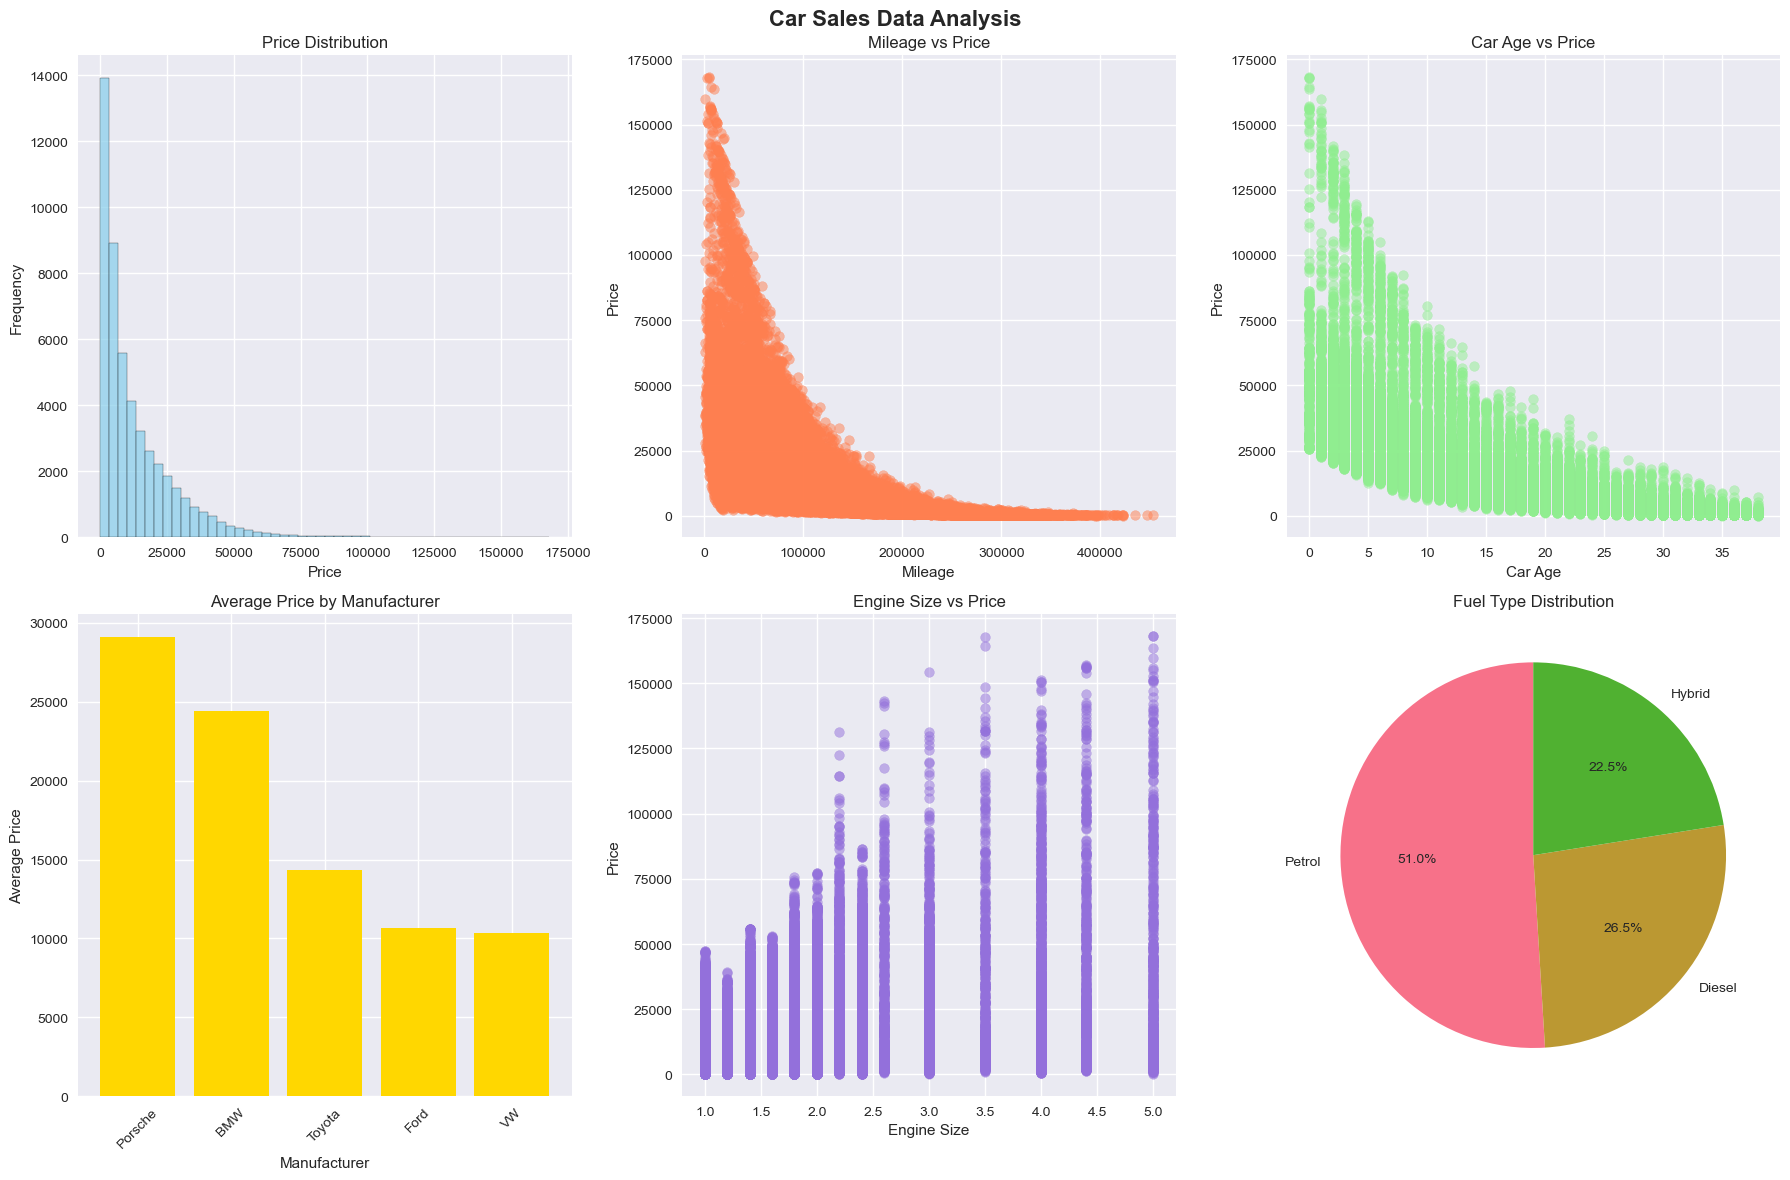

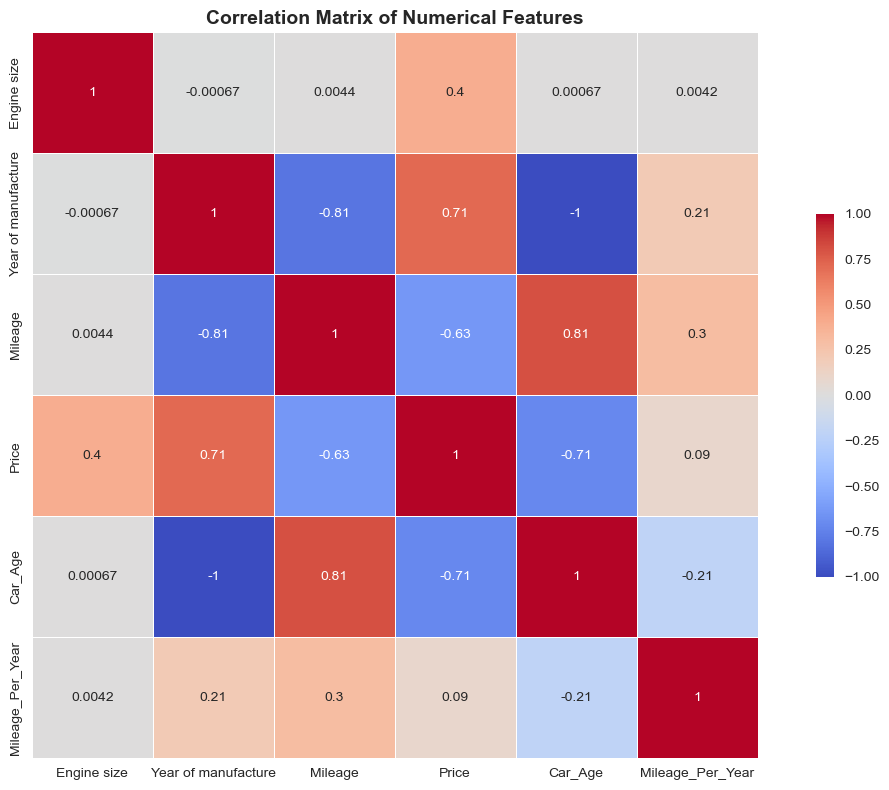

In [5]:
# DATA VISUALIZATION
print("\n" + "=" * 60)
print("DATA VISUALIZATION")
print("=" * 60)

# Set up the plotting area
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Car Sales Data Analysis', fontsize=16, fontweight='bold')

# Price distribution
axes[0, 0].hist(df['Price'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Price Distribution')
axes[0, 0].set_xlabel('Price')
axes[0, 0].set_ylabel('Frequency')

# Mileage vs Price
axes[0, 1].scatter(df['Mileage'], df['Price'], alpha=0.5, color='coral')
axes[0, 1].set_title('Mileage vs Price')
axes[0, 1].set_xlabel('Mileage')
axes[0, 1].set_ylabel('Price')

# Car Age vs Price
axes[0, 2].scatter(df['Car_Age'], df['Price'], alpha=0.5, color='lightgreen')
axes[0, 2].set_title('Car Age vs Price')
axes[0, 2].set_xlabel('Car Age')
axes[0, 2].set_ylabel('Price')

# Price by Manufacturer
manufacturer_prices = df.groupby('Manufacturer')['Price'].mean().sort_values(ascending=False)
axes[1, 0].bar(range(len(manufacturer_prices)), manufacturer_prices.values, color='gold')
axes[1, 0].set_title('Average Price by Manufacturer')
axes[1, 0].set_xlabel('Manufacturer')
axes[1, 0].set_ylabel('Average Price')
axes[1, 0].set_xticks(range(len(manufacturer_prices)))
axes[1, 0].set_xticklabels(manufacturer_prices.index, rotation=45)

# Engine Size vs Price
axes[1, 1].scatter(df['Engine size'], df['Price'], alpha=0.5, color='mediumpurple')
axes[1, 1].set_title('Engine Size vs Price')
axes[1, 1].set_xlabel('Engine Size')
axes[1, 1].set_ylabel('Price')

# Fuel Type distribution
fuel_counts = df['Fuel type'].value_counts()
axes[1, 2].pie(fuel_counts.values, labels=fuel_counts.index, autopct='%1.1f%%', startangle=90)
axes[1, 2].set_title('Fuel Type Distribution')

plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
numerical_cols = ['Engine size', 'Year of manufacture', 'Mileage', 'Price', 'Car_Age', 'Mileage_Per_Year']
correlation_matrix = df[numerical_cols].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix of Numerical Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [6]:
# FEATURE PREPARATION
print("\n" + "=" * 60)
print("FEATURE PREPARATION")
print("=" * 60)

# Select features for training
feature_columns = [
    'Engine size', 'Year of manufacture', 'Mileage', 'Car_Age', 
    'Mileage_Per_Year', 'Manufacturer', 'Model', 'Fuel type', 'Engine_Category'
]

X = df[feature_columns].copy()
y = df['Price'].copy()

# Store label encoders for later use
label_encoders = {}

# Encode categorical variables
categorical_columns = ['Manufacturer', 'Model', 'Fuel type', 'Engine_Category']

for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

print(f"Features prepared: {list(X.columns)}")
print(f"Feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")




FEATURE PREPARATION
Features prepared: ['Engine size', 'Year of manufacture', 'Mileage', 'Car_Age', 'Mileage_Per_Year', 'Manufacturer', 'Model', 'Fuel type', 'Engine_Category']
Feature matrix shape: (49988, 9)
Target variable shape: (49988,)



MODEL TRAINING
Training set size: (39990, 9)
Test set size: (9998, 9)
Performing hyperparameter tuning...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation score: 235547.99

MODEL EVALUATION
Training Set Metrics:
  MAE: 123.44
  RMSE: 182.03
  R²: 0.9999

Test Set Metrics:
  MAE: 191.84
  RMSE: 430.60
  R²: 0.9993

Mean Absolute Percentage Error:
  Training: 1.78%
  Test: 2.15%


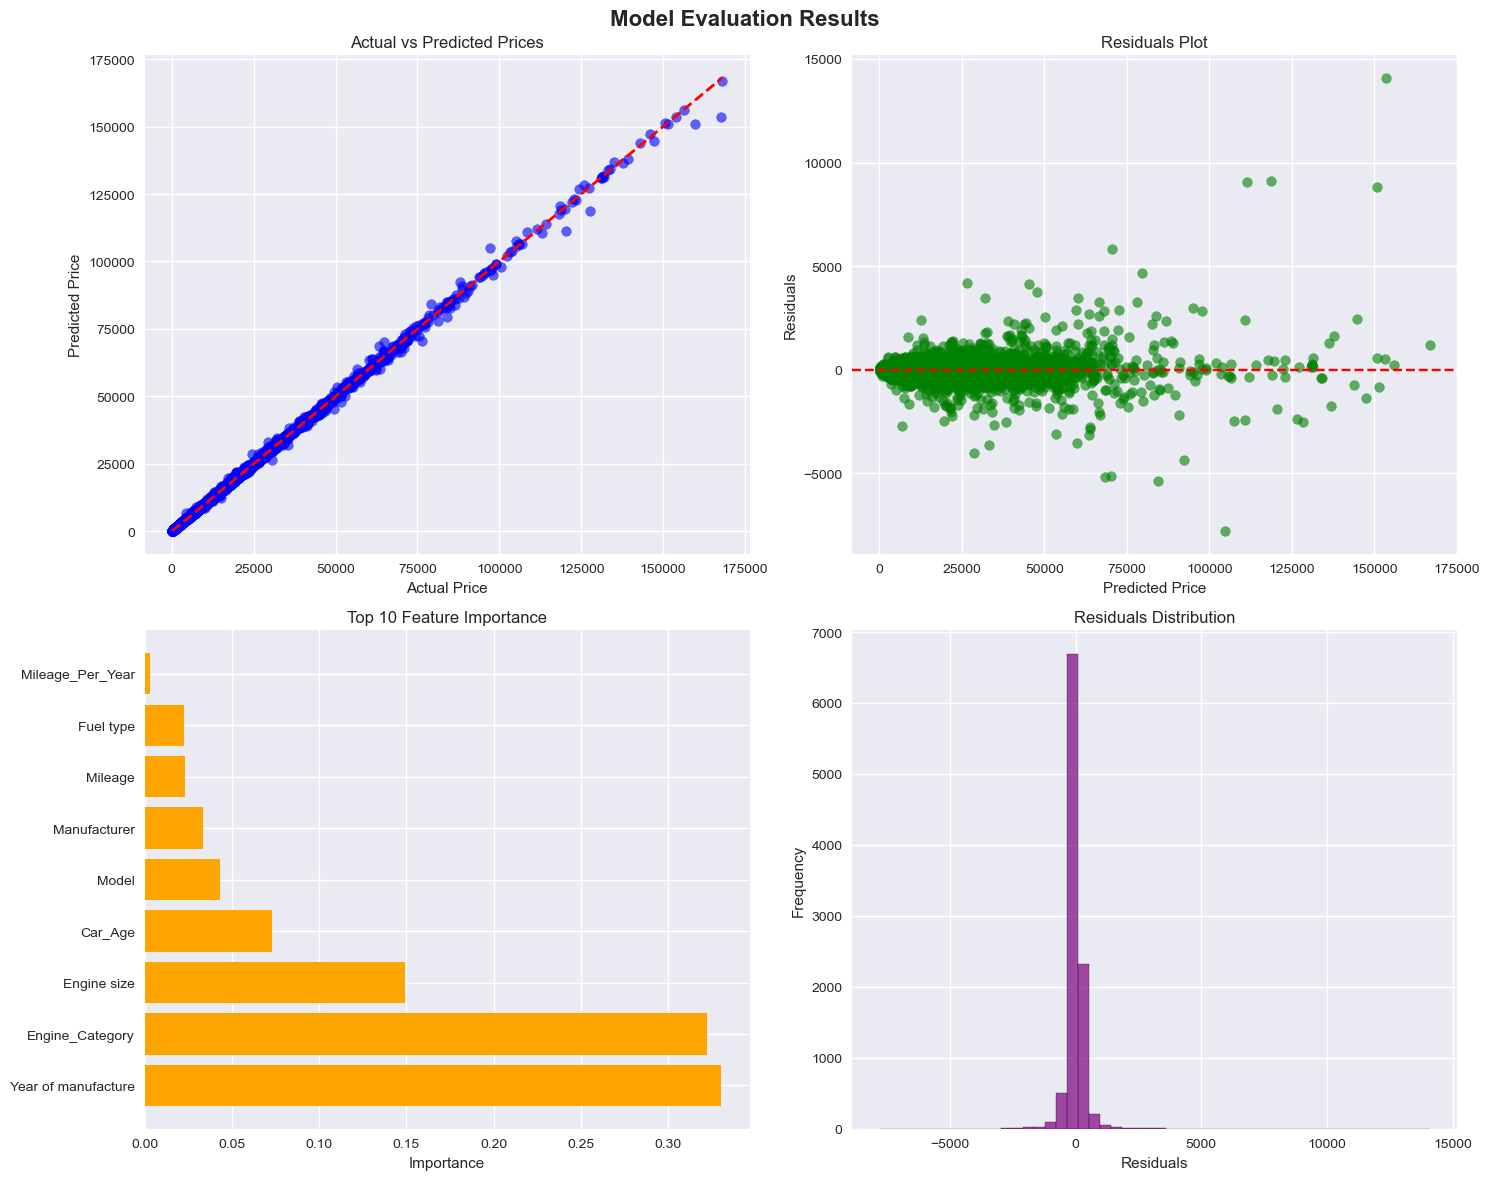

In [7]:
# MODEL TRAINING
print("\n" + "=" * 60)
print("MODEL TRAINING")
print("=" * 60)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Initialize XGBoost model with base parameters
base_model = xgb.XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror'
)

# Hyperparameter tuning with GridSearchCV
print("Performing hyperparameter tuning...")

# Using a smaller parameter grid for faster execution
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.15],
    'max_depth': [6, 8],
    'subsample': [0.8, 0.9]
}

grid_search = GridSearchCV(
    base_model, 
    param_grid, 
    cv=3, 
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# Best model
model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {-grid_search.best_score_:.2f}")

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# MODEL EVALUATION
print("\n" + "=" * 60)
print("MODEL EVALUATION")
print("=" * 60)

# Calculate metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Training Set Metrics:")
print(f"  MAE: {train_mae:.2f}")
print(f"  RMSE: {train_rmse:.2f}")
print(f"  R²: {train_r2:.4f}")

print("\nTest Set Metrics:")
print(f"  MAE: {test_mae:.2f}")
print(f"  RMSE: {test_rmse:.2f}")
print(f"  R²: {test_r2:.4f}")

# Calculate percentage errors
train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

print(f"\nMean Absolute Percentage Error:")
print(f"  Training: {train_mape:.2f}%")
print(f"  Test: {test_mape:.2f}%")

# EVALUATION PLOTS
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Evaluation Results', fontsize=16, fontweight='bold')

# Actual vs Predicted scatter plot
axes[0, 0].scatter(y_test, y_test_pred, alpha=0.6, color='blue')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Price')
axes[0, 0].set_ylabel('Predicted Price')
axes[0, 0].set_title('Actual vs Predicted Prices')

# Residuals plot
residuals = y_test - y_test_pred
axes[0, 1].scatter(y_test_pred, residuals, alpha=0.6, color='green')
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Predicted Price')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residuals Plot')

# Feature importance
top_features = feature_importance.head(10)
axes[1, 0].barh(range(len(top_features)), top_features['importance'], color='orange')
axes[1, 0].set_yticks(range(len(top_features)))
axes[1, 0].set_yticklabels(top_features['feature'])
axes[1, 0].set_xlabel('Importance')
axes[1, 0].set_title('Top 10 Feature Importance')

# Error distribution
axes[1, 1].hist(residuals, bins=50, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Residuals Distribution')

plt.tight_layout()
plt.show()



In [8]:
# SHAP ANALYSIS FOR MODEL INTERPRETABILITY
print("\n" + "=" * 60)
print("SHAP ANALYSIS - MODEL INTERPRETABILITY")
print("=" * 60)

# Initialize SHAP explainer
print("Initializing SHAP explainer...")
explainer = shap.Explainer(model)

# Calculate SHAP values for test set (using a sample for faster computation)
sample_size = min(500, len(X_test))  # Use up to 500 samples for faster computation
X_test_sample = X_test.head(sample_size)
y_test_sample = y_test.head(sample_size)

print(f"Calculating SHAP values for {sample_size} test samples...")
shap_values = explainer(X_test_sample)




SHAP ANALYSIS - MODEL INTERPRETABILITY
Initializing SHAP explainer...
Calculating SHAP values for 500 test samples...


Creating SHAP summary plot...


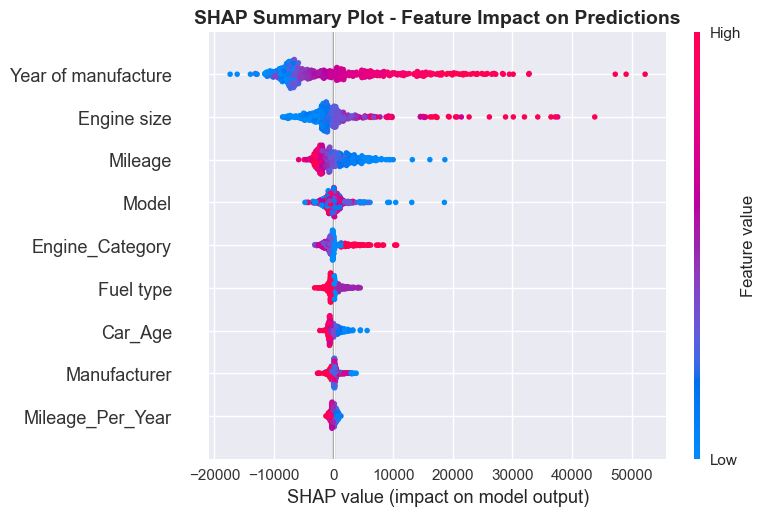

In [9]:
# SHAP Summary Plot
print("Creating SHAP summary plot...")
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_sample, feature_names=X.columns, show=False)
plt.title('SHAP Summary Plot - Feature Impact on Predictions', fontsize=14, fontweight='bold')
#plt.tight_layout()
plt.show()



Creating SHAP feature importance plot...


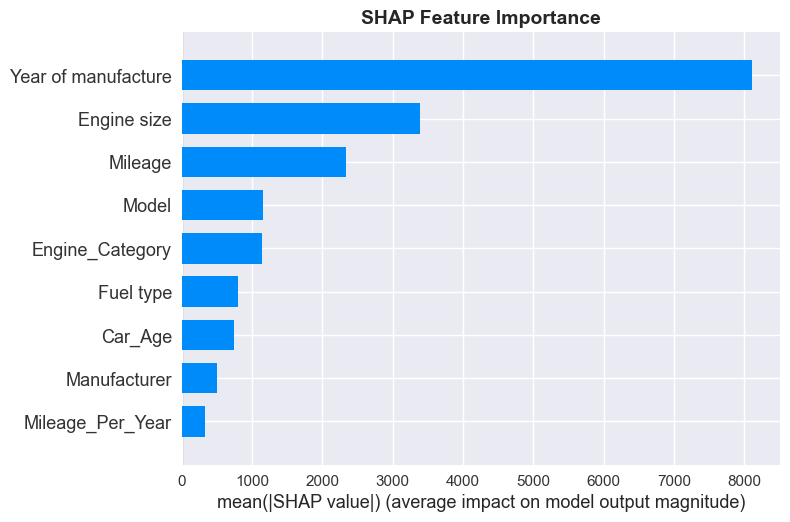

In [10]:
# SHAP Bar Plot (Feature Importance)
print("Creating SHAP feature importance plot...")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_sample, feature_names=X.columns, plot_type="bar", show=False)
plt.title('SHAP Feature Importance', fontsize=14, fontweight='bold')
#plt.tight_layout()
plt.show()



Creating SHAP dependence plots...
Creating dependence plot for: Year of manufacture


<Figure size 1000x600 with 0 Axes>

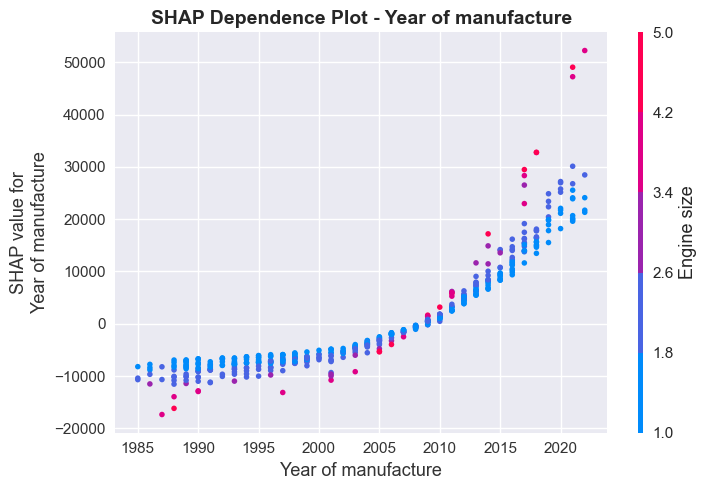

Creating dependence plot for: Engine_Category


<Figure size 1000x600 with 0 Axes>

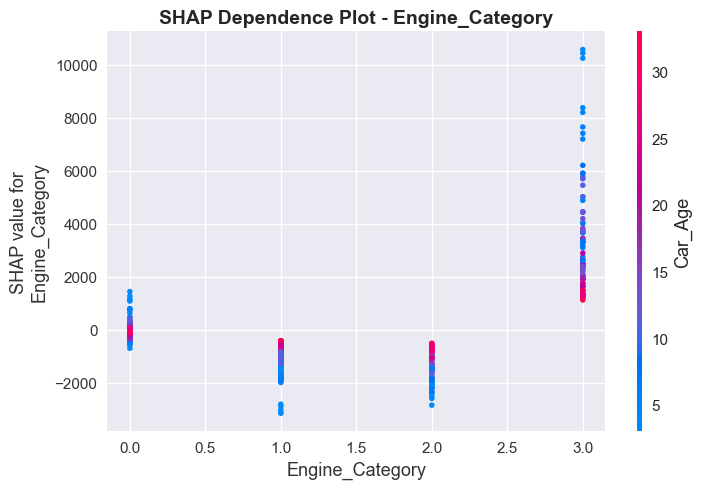

Creating dependence plot for: Engine size


<Figure size 1000x600 with 0 Axes>

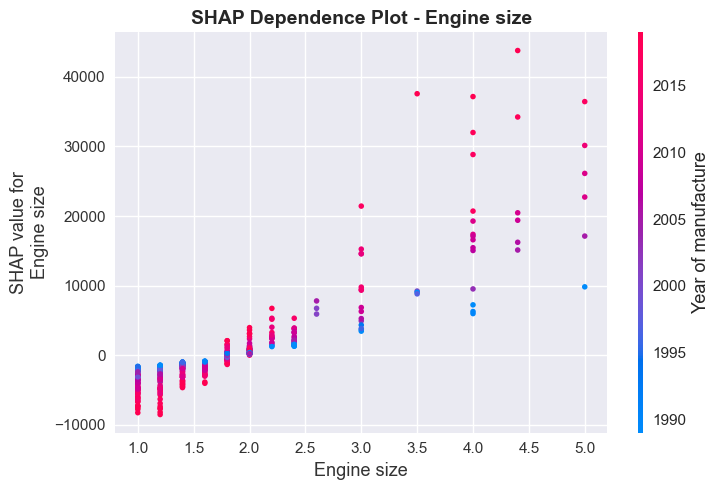

Creating dependence plot for: Car_Age


<Figure size 1000x600 with 0 Axes>

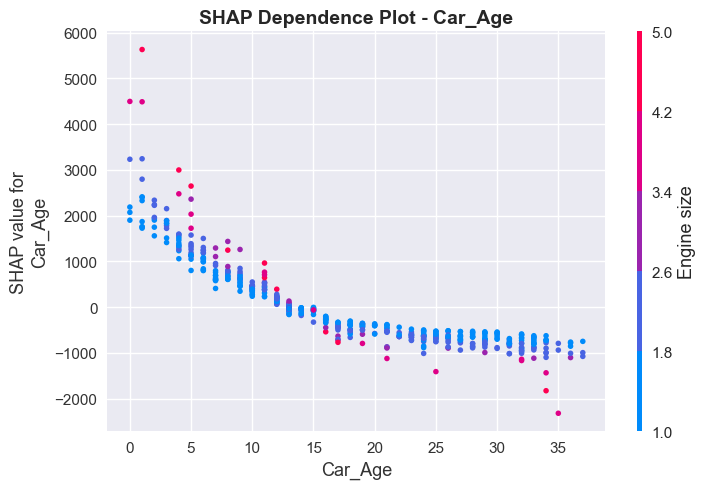

In [11]:
# SHAP Dependence Plots for top features (individual plots to avoid overlap)
print("Creating SHAP dependence plots...")
top_features = feature_importance.head(4)['feature'].tolist()

for idx, feature in enumerate(top_features):
    print(f"Creating dependence plot for: {feature}")
    
    # Get feature index
    feature_idx = list(X.columns).index(feature)
    
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(feature_idx, shap_values.values, X_test_sample, 
                        feature_names=X.columns, show=False)
    plt.title(f'SHAP Dependence Plot - {feature}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


Creating SHAP force plot...


Force plot created (works best in Jupyter notebook)

SHAP ANALYSIS SUMMARY
Top 10 Features by SHAP Importance:
               feature  mean_abs_shap
1  Year of manufacture    8102.062988
0          Engine size    3385.562500
2              Mileage    2336.127441
6                Model    1155.604858
8      Engine_Category    1143.544922
7            Fuel type     801.772888
3              Car_Age     743.452209
5         Manufacturer     503.942627
4     Mileage_Per_Year     327.351868

Feature Importance Comparison (XGBoost vs SHAP):
               feature  xgb_importance  shap_importance
0  Year of manufacture        0.330307      8102.062988
1      Engine_Category        0.322444      1143.544922
2          Engine size        0.149322      3385.562500
3              Car_Age        0.072981       743.452209
4                Model        0.043267      1155.604858
5         Manufacturer        0.033341       503.942627
6              Mileage        0.022982      2336.127441
7          

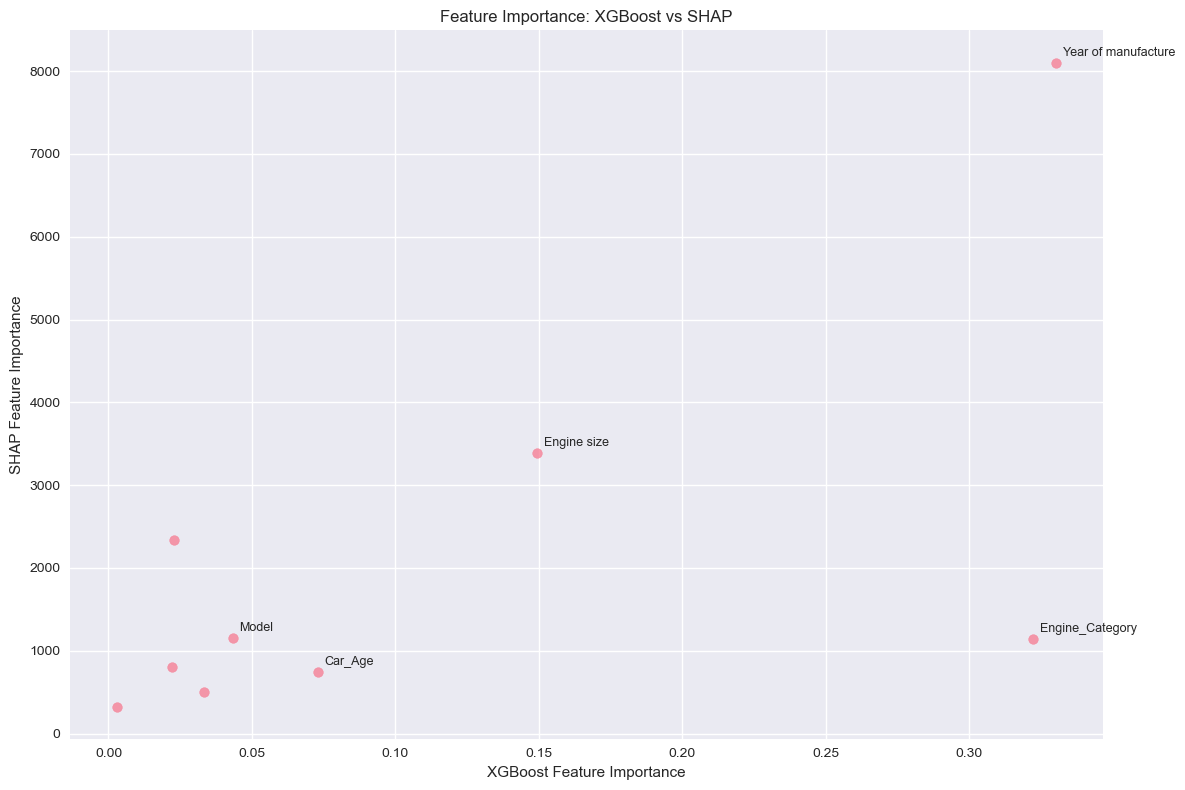

SHAP analysis completed for 500 samples.


In [12]:
# SHAP Force Plot for individual predictions (interactive)
print("Creating SHAP force plot...")
# Create force plot for the first prediction
shap.initjs()  # Initialize JavaScript for interactive plots

# Note: Force plots work best in Jupyter notebooks
# For script execution, we'll create a static version
try:
    # This creates an interactive plot in Jupyter
    force_plot = shap.force_plot(explainer.expected_value, shap_values[0].values, 
                                X_test_sample.iloc[0], feature_names=X.columns)
    print("Force plot created (works best in Jupyter notebook)")
except:
    print("Force plot requires Jupyter notebook environment for full interactivity")

# Calculate and display SHAP statistics
print("\n" + "=" * 50)
print("SHAP ANALYSIS SUMMARY")
print("=" * 50)

# Feature importance based on mean absolute SHAP values
shap_importance = pd.DataFrame({
    'feature': X.columns,
    'mean_abs_shap': np.mean(np.abs(shap_values.values), axis=0)
}).sort_values('mean_abs_shap', ascending=False)

print("Top 10 Features by SHAP Importance:")
print(shap_importance.head(10))

# Compare XGBoost feature importance vs SHAP importance
comparison_df = pd.merge(
    feature_importance.rename(columns={'importance': 'xgb_importance'}),
    shap_importance.rename(columns={'mean_abs_shap': 'shap_importance'}),
    on='feature'
)

print(f"\nFeature Importance Comparison (XGBoost vs SHAP):")
print(comparison_df.head(10))

# Plot comparison
plt.figure(figsize=(12, 8))
plt.scatter(comparison_df['xgb_importance'], comparison_df['shap_importance'], alpha=0.7)
plt.xlabel('XGBoost Feature Importance')
plt.ylabel('SHAP Feature Importance')
plt.title('Feature Importance: XGBoost vs SHAP')

# Add feature names for top features
top_comparison = comparison_df.head(5)
for idx, row in top_comparison.iterrows():
    plt.annotate(row['feature'], 
                (row['xgb_importance'], row['shap_importance']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.show()

print(f"SHAP analysis completed for {sample_size} samples.")



EXAMPLE PREDICTION WITH SHAP EXPLANATION
Basic prediction: $50575.73

Detailed prediction with SHAP explanation:

Prediction: $50575.73

SHAP Explanation:
----------------------------------------
Top contributing features:
  Year of manufacture: 2020.0 -> increases price by $25011.17
  Mileage: 25000.0 -> increases price by $4366.81
  Engine size: 2.0 -> increases price by $3486.36
  Fuel type: 2.0 -> decreases price by $2426.94
  Manufacturer: 3.0 -> increases price by $2394.15


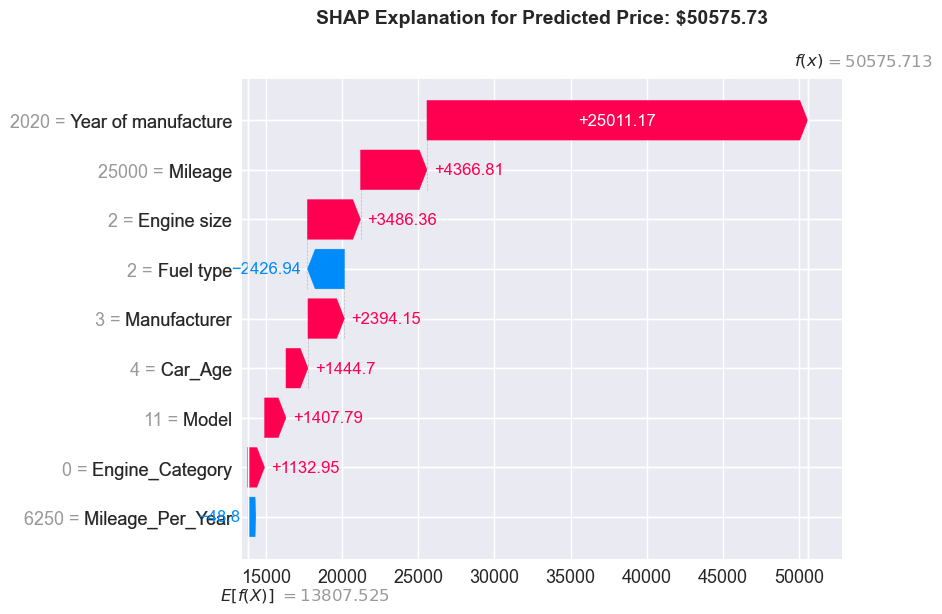


SECOND EXAMPLE - LUXURY CAR

Prediction: $66147.33

SHAP Explanation:
----------------------------------------
Top contributing features:
  Year of manufacture: 2021.0 -> increases price by $32826.58
  Engine size: 3.0 -> increases price by $14173.84
  Mileage: 15000.0 -> increases price by $8529.41
  Model: 12.0 -> decreases price by $7170.74
  Engine_Category: 3.0 -> increases price by $5393.53


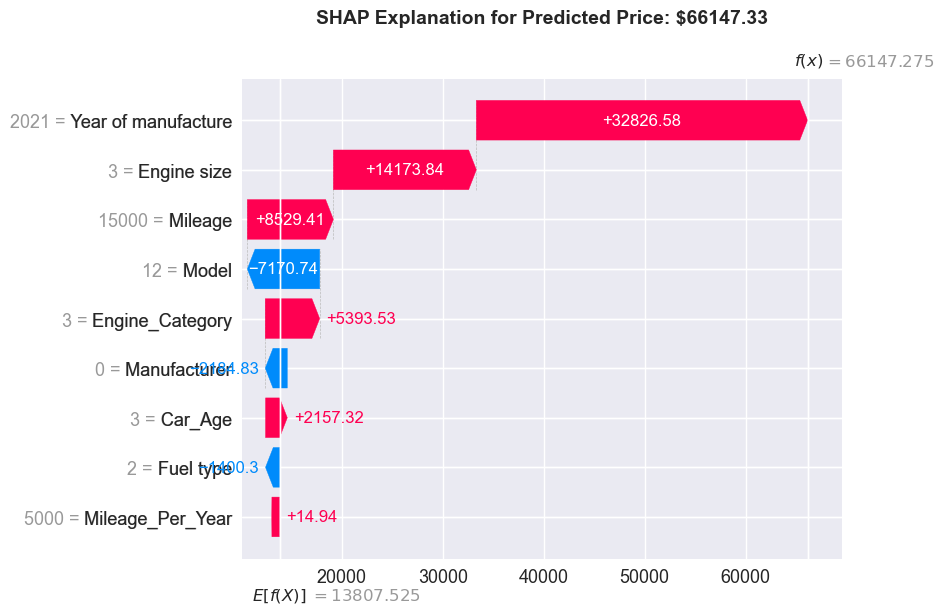


SAVING MODEL WITH SHAP EXPLAINER
Model with SHAP explainer saved to: car_price_xgboost_model_with_shap.pkl

To load the model with SHAP later, use:
model, label_encoders, feature_importance, shap_importance, explainer = load_saved_model_with_shap('car_price_xgboost_model_with_shap.pkl')

SHAP ANALYSIS COMPLETE
SHAP features added:
✓ Summary plots showing feature impact distribution
✓ Feature importance ranking based on SHAP values
✓ Dependence plots for top features
✓ Individual prediction explanations with waterfall plots
✓ Enhanced prediction function with explanation capability
✓ Comparison between XGBoost and SHAP feature importance
✓ Model interpretability for any new prediction

Key Insights:
- Most important feature (SHAP): Year of manufacture
- Most important feature (XGBoost): Year of manufacture
- Model can now explain why it makes specific predictions
- SHAP values help understand feature interactions and impacts


In [13]:
# PREDICTION FUNCTION WITH SHAP EXPLANATION
def predict_car_price(car_features, model, label_encoders, explain=False, explainer=None):
    """
    Predict price for new car data with optional SHAP explanation
    """
    # Convert input to DataFrame if it's not already
    if isinstance(car_features, dict):
        car_features = pd.DataFrame([car_features])
    
    # Encode categorical variables
    car_features_encoded = car_features.copy()
    for col in ['Manufacturer', 'Model', 'Fuel type', 'Engine_Category']:
        if col in car_features_encoded.columns and col in label_encoders:
            car_features_encoded[col] = label_encoders[col].transform(car_features_encoded[col].astype(str))
    
    # Make prediction
    prediction = model.predict(car_features_encoded)
    
    if explain and explainer is not None:
        # Get SHAP explanation for this prediction
        shap_values_single = explainer(car_features_encoded)
        
        print(f"\nPrediction: ${prediction[0]:.2f}")
        print("\nSHAP Explanation:")
        print("-" * 40)
        
        # Create explanation DataFrame
        explanation_df = pd.DataFrame({
            'Feature': car_features_encoded.columns,
            'Value': car_features_encoded.iloc[0].values,
            'SHAP_Value': shap_values_single[0].values,
            'Contribution': shap_values_single[0].values
        })
        
        # Sort by absolute SHAP value
        explanation_df['Abs_SHAP'] = np.abs(explanation_df['SHAP_Value'])
        explanation_df = explanation_df.sort_values('Abs_SHAP', ascending=False)
        
        # Display top contributing features
        print("Top contributing features:")
        for idx, row in explanation_df.head(5).iterrows():
            impact = "increases" if row['SHAP_Value'] > 0 else "decreases"
            print(f"  {row['Feature']}: {row['Value']} -> {impact} price by ${abs(row['SHAP_Value']):.2f}")
        
        # Create waterfall plot for this prediction
        plt.figure(figsize=(14, 10))
        shap.waterfall_plot(shap_values_single[0], show=False)
        plt.title(f'SHAP Explanation for Predicted Price: ${prediction[0]:.2f}', 
                  fontsize=14, fontweight='bold', pad=20)
        plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.1)
        plt.show()
        
        return prediction, explanation_df
    
    return prediction

# EXAMPLE PREDICTION WITH SHAP EXPLANATION
print("\n" + "=" * 60)
print("EXAMPLE PREDICTION WITH SHAP EXPLANATION")
print("=" * 60)

# Example: Make predictions on new data with SHAP explanation
new_car = {
    'Engine size': 2.0,
    'Year of manufacture': 2020,
    'Mileage': 25000,
    'Car_Age': 4,
    'Mileage_Per_Year': 6250,
    'Manufacturer': 'Toyota',
    'Model': 'RAV4',
    'Fuel type': 'Petrol',
    'Engine_Category': 'Large'
}

# Prediction without explanation
price_prediction = predict_car_price(new_car, model, label_encoders)
print(f"Basic prediction: ${price_prediction[0]:.2f}")

# Prediction with SHAP explanation
print("\nDetailed prediction with SHAP explanation:")
price_prediction_explained, explanation_df = predict_car_price(
    new_car, model, label_encoders, explain=True, explainer=explainer
)

# Example with different car
print("\n" + "=" * 60)
print("SECOND EXAMPLE - LUXURY CAR")
print("=" * 60)

luxury_car = {
    'Engine size': 3.0,
    'Year of manufacture': 2021,
    'Mileage': 15000,
    'Car_Age': 3,
    'Mileage_Per_Year': 5000,
    'Manufacturer': 'BMW',
    'Model': 'X3',
    'Fuel type': 'Petrol',
    'Engine_Category': 'Very_Large'
}

luxury_prediction, luxury_explanation = predict_car_price(
    luxury_car, model, label_encoders, explain=True, explainer=explainer
)

# SAVE MODEL WITH SHAP EXPLAINER
print("\n" + "=" * 60)
print("SAVING MODEL WITH SHAP EXPLAINER")
print("=" * 60)

# Save model, encoders, and explainer
model_data = {
    'model': model,
    'label_encoders': label_encoders,
    'feature_importance': feature_importance,
    'shap_importance': shap_importance,
    'explainer': explainer  # Save explainer for future use
}

joblib.dump(model_data, "car_price_xgboost_model_with_shap.pkl")
print("Model with SHAP explainer saved to: car_price_xgboost_model_with_shap.pkl")

# LOAD MODEL EXAMPLE (for future use)
def load_saved_model_with_shap(filepath):
    """
    Load a pre-trained model with SHAP explainer
    """
    model_data = joblib.load(filepath)
    return (model_data['model'], model_data['label_encoders'], 
            model_data['feature_importance'], model_data['shap_importance'],
            model_data['explainer'])

print("\nTo load the model with SHAP later, use:")
print("model, label_encoders, feature_importance, shap_importance, explainer = load_saved_model_with_shap('car_price_xgboost_model_with_shap.pkl')")

# SHAP ANALYSIS SUMMARY
print("\n" + "=" * 60)
print("SHAP ANALYSIS COMPLETE")
print("=" * 60)
print("SHAP features added:")
print("✓ Summary plots showing feature impact distribution")
print("✓ Feature importance ranking based on SHAP values") 
print("✓ Dependence plots for top features")
print("✓ Individual prediction explanations with waterfall plots")
print("✓ Enhanced prediction function with explanation capability")
print("✓ Comparison between XGBoost and SHAP feature importance")
print("✓ Model interpretability for any new prediction")

print(f"\nKey Insights:")
print(f"- Most important feature (SHAP): {shap_importance.iloc[0]['feature']}")
print(f"- Most important feature (XGBoost): {feature_importance.iloc[0]['feature']}")
print(f"- Model can now explain why it makes specific predictions")
print(f"- SHAP values help understand feature interactions and impacts")